In [21]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

filepath = "PQEvents_Ticket_csv.csv"


In [22]:
df = pd.read_csv(filepath)
print(f"Data sample:]n{df.head()}")

df = df.rename(columns=lambda x: x.replace(" ", "_"))

output_names = ["Cause", "Isolation_Equipment_Code"]
# output_names = ["Cause", "Isolation_Equipment_Code", "Failed_Equipment_Code"]

column_names = []
for label in output_names:
    column_names.append(label)
column_names.append("Details")

df = df.filter(items=column_names)

print(f"Data sample:\n{df.head()}\n")

def clean_data(df) -> pd.DataFrame:
    # Replace punctuation with whitespace
    def remove_punctuation(value):
        for token in invalid_tokens:
            value = value.replace(token, " ")
        return value

    # Strip whitespace if more than one sequential whitespace is found
    def strip_excess_whitespace(value):
          # Replace multiple whitespaces with a single whitespace
          value = re.sub(r'\s{2,}', ' ', value)
          # Strip leading and trailing whitespaces
          return value.strip()

    df = df.dropna()

    invalid_tokens = [",", "/", ".", "-","(", ")"]

    df = df.map(lambda x: x.lower())
    df = df.replace("unknown", np.nan)
    df = df.replace("undetermined", np.nan)
    df = df.replace("unknonw", np.nan)
    df = df.dropna()
    df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')


    df = df.map(remove_punctuation)

    df = df.map(strip_excess_whitespace)

    return df

df = clean_data(df)
print(f"\nFinal Data sample:\n{df.head()}\n")

pq_train = df.pop("Details")

# print(f"Training data examples:\n{pq_train.head()}\n")

output_labels = {label_name: df.pop(label_name) for label_name in output_names}

# Convert to numpy array
pq_train = pq_train.to_numpy()
for name in output_names:
    output_labels[name] = output_labels[name].to_numpy()

# print(output_labels)
# ds = tf.data.Dataset.from_tensor_slices((pq_train, tuple(output_labels[name] for name in output_names)))
# print(f"{list(ds.take(1).as_numpy_iterator())}")

MAX_LENGTH = 16


def fit_vectorizer(dataset):
    """
    Adapts the TextVectorization layer on the training sentences
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with training sentences.
    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization class adapted to the training sentences.
    """
    # Instantiate the TextVectorization class
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=None, #let the layer learn the vocab size from the sequences
        output_sequence_length=MAX_LENGTH
    )
    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)
    return vectorizer

def fit_label_encoder(labels):
    """Creates an instance of a StringLookup, and trains it on all labels
    Args:
        labels (tf.data.Dataset): dataset of labels
    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    num_oov_tokens = 1

    # Instantiate the StringLookup layer with no OOV tokens
    label_encoder = tf.keras.layers.StringLookup(
                                    max_tokens=(MAX_LENGTH + num_oov_tokens),
                                    num_oov_indices=num_oov_tokens)
    # If new words appear in validation or test data that weren't in the training set,
    # these words can be mapped to the OOV token,
    # allowing the model to continue processing the data without encountering issues

    # Fit the StringLookup layer on the labels
    label_encoder.adapt(labels)
    return label_encoder

def preprocess_dataset(dataset, text_vectorizer, label_encoders, output_names):
    """Apply the preprocessing to a dataset
    Args:
        dataset (tf.data.Dataset): dataset to preprocess (training or validation)
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder
    Returns:
        tf.data.Dataset: transformed dataset
    """
    def encode_labels_fn(text, label_dict):
        encoded_labels = {name: label_encoders[name](label_dict[name]) for name in output_names}
        return text_vectorizer(text), encoded_labels

    return dataset.map(encode_labels_fn)

TRAINING_SPLIT = 0.8
NUM_BATCHES = 16

def create_model(vocab_size, num_labels_dict, output_names):
    """
    Creates a text classifier model with separate output layers for each target.
    Args:
        vocab_size (int): Size of the vocabulary for the text vectorization layer.
        num_labels_dict (dict): Dictionary mapping each output name to its number of unique labels.
    Returns:
        tf.keras.Model: Compiled Keras model ready for training.
    """
    EMBEDDING_DIM = 256

    # Input layer for tokenized text sequences 
    input_layer = tf.keras.Input(shape=(MAX_LENGTH,), name="input_text")
    
    # Hidden layers
    x = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, name="embedding_layer")(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2, name="bi_lstm_layer_1"))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2, name="bi_lstm_layer_2"))(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="dense_layer_1")(x)
    x = tf.keras.layers.Dropout(0.2, name="dropout_layer_1")(x)
    x = tf.keras.layers.Dense(64, activation='relu', name="dense_layer_2")(x)

    # Output layers for each target
    outputs = [tf.keras.layers.Dense(num_labels_dict[name],
                                   activation='softmax',
                                   name=name
                                   )(x) for name in output_names]

    # Define the model (removed output swapping since we only have 2 outputs)
    model = tf.keras.Model(inputs=input_layer, outputs=outputs, name="multi_output_model")

    # Compile the model
    loss_dict = {name: 'sparse_categorical_crossentropy' for name in output_names}
    metrics_dict = {name: 'accuracy' for name in output_names}

    model.compile(
        optimizer='adam',
        loss=loss_dict,
        metrics=metrics_dict
    )

    return model

# Print Data Shapes
print(f"Training Data Dims:{pq_train.shape}\nOutput Label Dims:")
for name in output_names:
    print(f"\t{name}: {output_labels[name].shape}")

# Print Data
# print(f"Training Data:{pq_train}\nOutput Labels:")
# for name in output_names:
#     print(f"\t{name}:\n{output_labels[name]}")


Data sample:]n   id  SiteName   FeederId  EventId  Phase First Event Last Event      Cause  \
0   1  Site0006  F_0000041     3042      4     39:06.0    39:06.0  Equipment   
1   2  Site0012  F_0000037     3048      3     29:36.0    29:51.0  Equipment   
2   3  Site0006  F_0000041     3067      2     10:46.0    10:46.0    Weather   
3   4  Site0012  F_0000037     3127      2     33:30.0    33:30.0  Equipment   
4   6  Site0006  F_0000041     3152      2     39:58.0    39:58.0  Equipment   

   Weather Isolation Equipment Code Failed Equipment Code  \
0  Unknown                     Fuse                 Other   
1  Unknown                  Breaker             Capacitor   
2     Wind                  Breaker             No Damage   
3  Unknown                     Fuse           Transformer   
4  Unknown                     Fuse           Transformer   

                                  Details  
0          Equipment, Device UG, Damaged.  
1  Equipment, Capacitor Station, Damaged.  
2   Un

In [23]:
def train_model(pq_train, output_labels):

    vectorizer = fit_vectorizer(pq_train)
    vocab_size = vectorizer.vocabulary_size()

    label_encoders = {}
    label_nums = {}
    label_vocabs = {}

    for name in output_names:
        label_encoders[name] = fit_label_encoder(output_labels[name])
        label_nums[name] = label_encoders[name].vocabulary_size()
        label_vocabs[name] = label_encoders[name].get_vocabulary()

    model = create_model(vocab_size, label_nums, output_names)
    model.summary()

    print("Model outputs:", model.output_names)


    def dynamic_train_test_split(X, y, test_size=0.2, random_state=42, stratify=None):
        # Ensure consistent ordering of label keys
        keys = list(y.keys())
        y_values = [y[key] for key in keys]

        # Perform train-test split dynamically
        split_data = train_test_split(
            X, *y_values, test_size=test_size, random_state=random_state, stratify=stratify
        )
        # print(f"{split_data}")
        for i, data in enumerate(split_data):
            print(f"Data[{i}]: {data.shape}")
        print()

        # Reconstruct the train and test splits for labels
        X_train, X_test = split_data[0], split_data[1]

        y_train = {key: split_data[2 + 2*i] for i, key in enumerate(keys)}
        y_test = {key: split_data[3 + 2*i] for i, key in enumerate(keys)}

        return X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = dynamic_train_test_split(pq_train,
                                                      output_labels
                                                      )

    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    for name in output_names:
        print(f"{name} y_train: {y_train[name].shape}")
        print(f"{name} y_test: {y_test[name].shape}")
    print()

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    proc_train_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoders, output_names)
    proc_test_dataset = preprocess_dataset(test_dataset, vectorizer, label_encoders, output_names)

    batch_train_dataset = proc_train_dataset.batch(NUM_BATCHES, drop_remainder=False)
    batch_test_dataset = proc_test_dataset.batch(NUM_BATCHES, drop_remainder=False)

    # for text, label_dict in batch_train_dataset.as_numpy_iterator():
    #     print(f"Train Text: {text}")
    #     for name, label in label_dict.items():
    #         print(f"Train {name} label: {label}")
    # print()
    # for text, label_dict in batch_test_dataset.as_numpy_iterator():
    #     print(f"Test Text: {text}")
    #     for name, label in label_dict.items():
    #         print(f"Test {name} label: {label}")
    # print()
    # for name in output_names:
    #     print(f"{name} num_labels: {label_nums[name]}")
    # print()

    history = model.fit(
        batch_train_dataset,
        epochs=100,
        validation_data=batch_test_dataset,
        verbose=2,
        batch_size=NUM_BATCHES,
    )

    # Evaluate the model and store metrics
    all_val_loss = {}
    all_val_acc = {}
    for name in output_names:
        metrics = model.evaluate(batch_test_dataset, verbose=0, return_dict=True)
        all_val_loss[name] = metrics[name + "_loss"]  # Store loss for each output
        all_val_acc[name] = metrics[name + "_accuracy"]  # Store accuracy for each output

    # Print and store metrics
    for name in output_names:
        print(f"{name} Validation Accuracy: {all_val_acc[name]}")
        print(f"{name} Validation Loss: {all_val_loss[name]}")
    return history, model, batch_train_dataset, batch_test_dataset, label_vocabs


history, model, batch_train_dataset, batch_val_dataset, label_vocabs = train_model(pq_train, output_labels)

Model: "multi_output_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 16, 256)   │     57,856 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 16, 128)   │    164,352 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64)        │     41,216 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_1       │ (None, 128)       │      8,320 │ bidirectional_5[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer_1     │ (None, 128)       │          0 │ dense_layer_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_2       │ (None, 64)        │      8,256 │ dropout_layer_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Cause (Dense)       │ (None, 10)        │        650 │ dense_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Isolation_Equipmen… │ (None, 15)        │        975 │ dense_layer_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 281,625 (1.07 MB)

 Trainable params: 281,625 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Model outputs: ListWrapper(['Cause', 'Isolation_Equipment_Code'])
Data[0]: (138,)
Data[1]: (35,)
Data[2]: (138,)
Data[3]: (35,)
Data[4]: (138,)
Data[5]: (35,)

X_train: (138,)
X_test: (35,)
Cause y_train: (138,)
Cause y_test: (35,)
Isolation_Equipment_Code y_train: (138,)
Isolation_Equipment_Code y_test: (35,)

Epoch 1/100
9/9 - 10s - 1s/step - Cause_accuracy: 0.3188 - Cause_loss: 2.2650 - Isolation_Equipment_Code_accuracy: 0.2609 - Isolation_Equipment_Code_loss: 2.6816 - loss: 4.9482 - val_Cause_accuracy: 0.5714 - val_Cause_loss: 2.1387 - val_Isolation_Equipment_Code_accuracy: 0.3714 - val_Isolation_Equipment_Code_loss: 2.7058 - val_loss: 4.7359
Epoch 2/100
9/9 - 0s - 48ms/step - Cause_accuracy: 0.4348 - Cause_loss: 1.9810 - Isolation_Equipment_Code_accuracy: 0.3913 - Isolation_Equipment_Code_loss: 2.4542 - loss: 4.4308 - val_Cause_accuracy: 0.5429 - val_Cause_loss: 1.7557 - val_Isolation_Equipment_Code_accuracy: 0.3714 - val_Isolation_Equipment_Code_loss: 2.8527 - val_loss: 3.9828
Ep

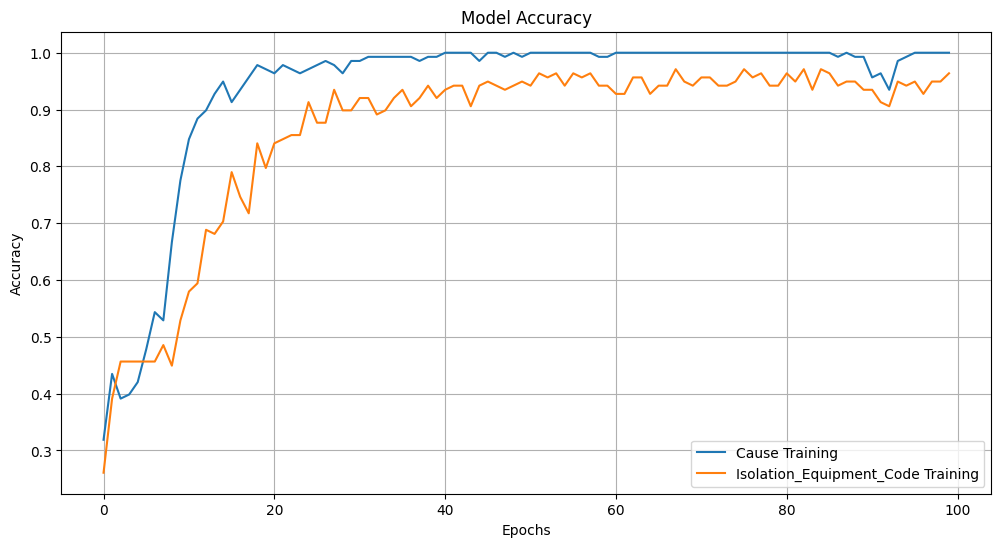

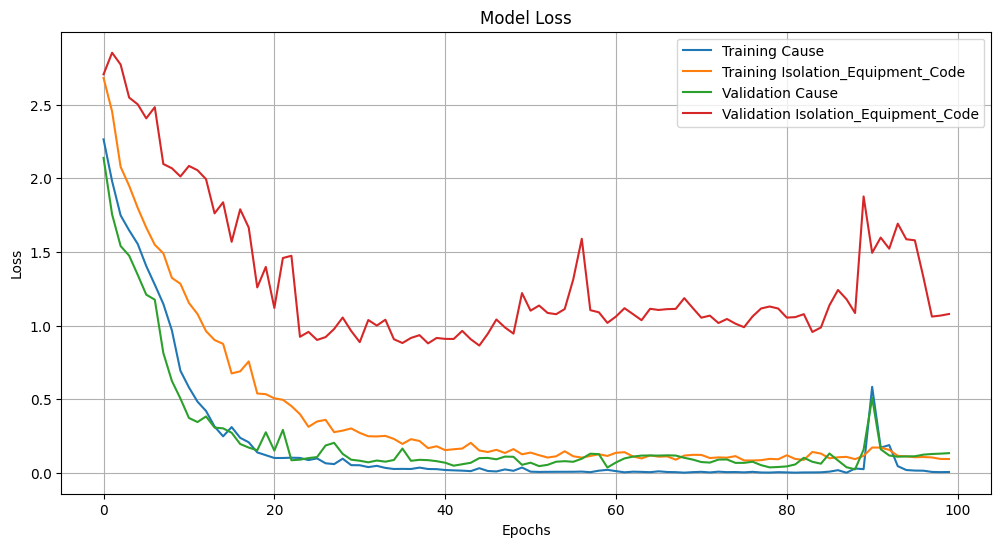

In [24]:
def plot_training_history(history) -> None:
    # Plot training accuracy only
    plt.figure(figsize=(12, 6))
    for output_name in history.history.keys():
        if "accuracy" in output_name and "val" not in output_name:  # Skip validation accuracy
            label = output_name.replace("_accuracy", " Training").title()
            plt.plot(history.history[output_name], label=label)
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    for output_name in history.history.keys():
        if "loss" in output_name:
            # Skip overall loss
            if output_name in ["loss", "val_loss"]:
                continue
            # Make loss labels more descriptive
            if "val" in output_name:
                label = output_name.replace("val_", "Validation ").replace("_loss", "")
            else:
                label = "Training " + output_name.replace("_loss", "")
            plt.plot(history.history[output_name], label=label)
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [25]:
def create_accuracy_table(history, output_names, batch_train_dataset, label_vocabs):
    """
    Creates and displays a formatted table showing precision, recall, f1-score
    and support for training data
    Args:
        history: Training history from model.fit()
        output_names: List of output layer names
        batch_train_dataset: Training dataset in batches
        label_vocabs: Dictionary of label vocabularies
    """
    # Get predictions on training data
    train_predictions = model.predict(batch_train_dataset) 
    
    print("\nTraining Performance Metrics:")
    print("-" * 80)
    
    for i, name in enumerate(output_names):
        # Get predictions and true labels for current output
        y_pred = np.argmax(train_predictions[i], axis=1)
        y_true = []
        for _, labels in batch_train_dataset:
            y_true.extend(labels[name].numpy())
        y_true = np.array(y_true)
        
        # Convert numeric labels back to strings
        str_true = [label_vocabs[name][label] for label in y_true]
        str_pred = [label_vocabs[name][label] for label in y_pred]
        
        # Sort unique classes alphabetically
        classes = sorted(list(set(str_true)))
        
        print(f"\nClassification Report for {name}:")
        print(classification_report(
            str_true, 
            str_pred,
            target_names=classes,
            digits=2,
            zero_division=0.0
        ))
        print("-" * 80)

# Update how you call the function:
metrics_table = create_accuracy_table(history, output_names, batch_train_dataset, label_vocabs)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step

Training Performance Metrics:
--------------------------------------------------------------------------------

Classification Report for Cause:
                 precision    recall  f1-score   support

         animal       1.00      1.00      1.00         7
customer caused       1.00      1.00      1.00         1
      equipment       1.00      1.00      1.00        54
      lightning       1.00      1.00      1.00        17
          other       1.00      1.00      1.00         4
        planned       1.00      1.00      1.00         1
           tree       1.00      1.00      1.00        34
        vehicle       1.00      1.00      1.00        17
        weather       1.00      1.00      1.00         3

       accuracy                           1.00       138
      macro avg       1.00      1.00      1.00       138
   weighted avg       1.00      1.00      1.00       138

-----------------------------------------------------------------------

In [26]:
# Predict on the validation dataset
all_predictions = model.predict(batch_val_dataset)

# Split predictions into respective outputs
predictions = {}
true_labels = {}
classes = {}
num_classes = {}

for i, name in enumerate(output_names):
    # Create dictionary of true labels for each output
    true_labels[name] = []
    for _, labels in batch_val_dataset:
        true_labels[name].extend(labels[name].numpy())
    # Create dictionary of each predicted output
    predictions[name] = np.argmax(all_predictions[i], axis=1)
    # Convert true labels to NumPy array
    true_labels[name] = np.array(true_labels[name])
    # Create dictionary of all distinct classes
    classes[name] = np.unique(output_labels[name])
    # Create dictionary of number of total classes
    num_classes[name] = np.arange(len(classes[name]))

# Remove the swapping code since you only have 2 outputs now
# The following lines should be removed:
# temp = predictions[output_names[1]]
# predictions[output_names[1]] = predictions[output_names[2]]
# predictions[output_names[2]] = temp
print("Validation/test results")
str_true_labels = {}
str_predictions = {}
for name in output_names:
    str_true_labels[name] = [label_vocabs[name][label] for label in true_labels[name]]
    str_predictions[name] = [label_vocabs[name][label] for label in predictions[name]]
    print(f"\nClassification Report for {name}:")
    print(classification_report(str_true_labels[name], str_predictions[name], zero_division=0.0))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation/test results

Classification Report for Cause:
              precision    recall  f1-score   support

   equipment       1.00      0.95      0.97        19
   lightning       1.00      1.00      1.00         4
     planned       1.00      1.00      1.00         1
        tree       0.83      1.00      0.91         5
     vehicle       1.00      1.00      1.00         6

    accuracy                           0.97        35
   macro avg       0.97      0.99      0.98        35
weighted avg       0.98      0.97      0.97        35


Classification Report for Isolation_Equipment_Code:
               precision    recall  f1-score   support

      breaker       0.86      0.92      0.89        13
         co15       0.00      0.00      0.00         1
       co15lb       1.00      1.00      1.00         1
         fuse       1.00      0.75      0.86         8
          ocb       0.00      0.00      0.00         1
      r100 4e       1.00      1

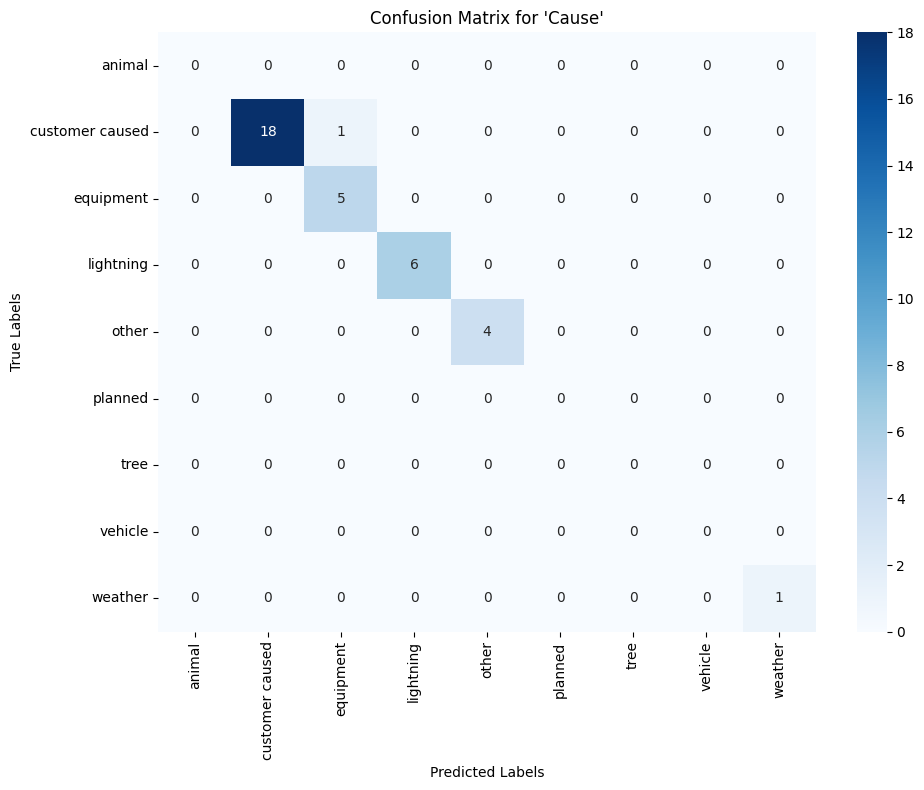

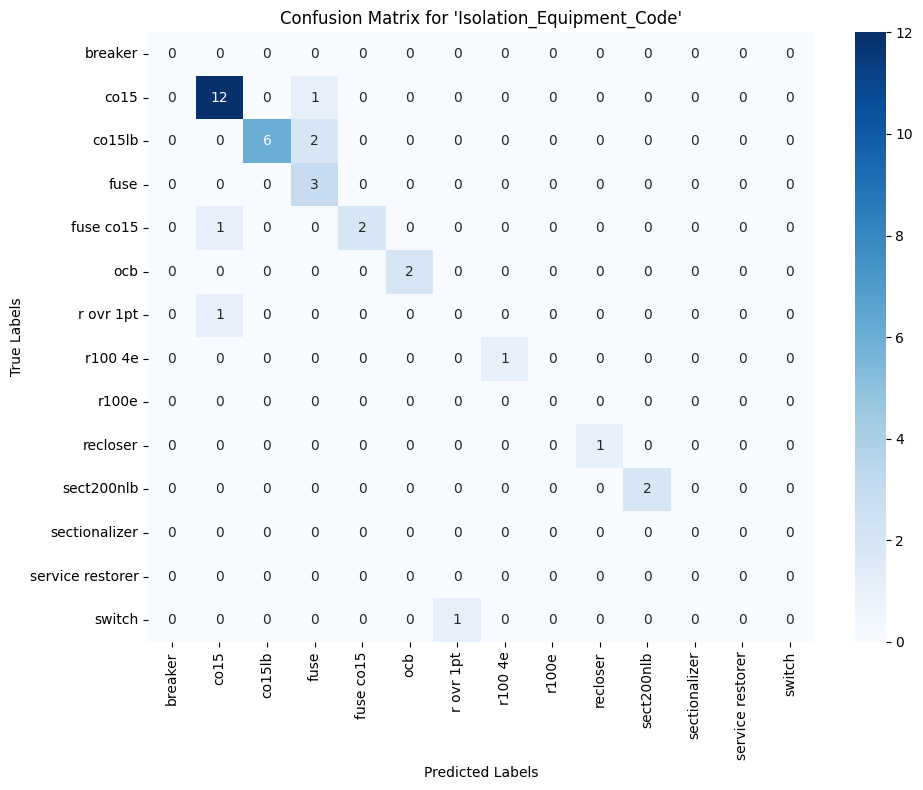

In [27]:
# Create confusion matrices for each output
cms = {}

for name in output_names:
    plt.figure(figsize=(10, 8))
    cms[name] = confusion_matrix(true_labels[name], predictions[name], labels=num_classes[name])
    sns.heatmap(cms[name], annot=True, fmt="d", cmap="Blues",
                xticklabels=classes[name],
                yticklabels=classes[name])
    plt.title(f"Confusion Matrix for \'{name}\'")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()